In [22]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs

In [3]:
%matplotlib inline

In [38]:
import cartopy
cartopy.__version__

'0.16.0'

# Example 1: Cartopy subplots

This is the simplest approach when making multiple subplots.

In [83]:
import cartopy.feature as cfeature

def layout_ax(ax):    
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN) ## BUG in cartopy 0.16: draws ocean everywhere on NorthPolarStereo projection
    ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.COASTLINE)

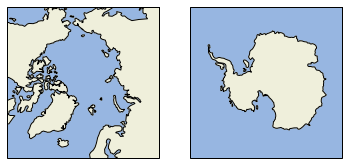

In [85]:
fig = plt.figure()
ax1 = plt.subplot(121, projection=ccrs.NorthPolarStereo())
ax1.set_extent((-180,180,60,90), crs=ccrs.PlateCarree())

ax2 = plt.subplot(122, projection=ccrs.SouthPolarStereo())
ax2.set_extent((-180,180,-90,-60), crs=ccrs.PlateCarree())

layout_ax(ax1)
layout_ax(ax2)

# Example 2: Cartopy subplots using GridSpec 
[GridSpec](https://matplotlib.org/users/gridspec.html) is a more versatile way of creating subplots.

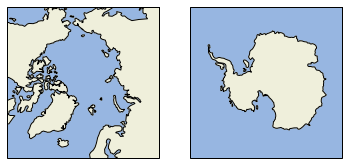

In [86]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(gs[0,0], projection=ccrs.NorthPolarStereo())
ax1.set_extent((-180,180,60,90), crs=ccrs.PlateCarree())


ax2 = plt.subplot(gs[0,1], projection=ccrs.SouthPolarStereo())
ax2.set_extent((-180,180,-90,-60), crs=ccrs.PlateCarree())


layout_ax(ax1)
layout_ax(ax2)

# Example 3: custom Axes boundary

Polar maps look better when they have a circular shape!

In [55]:
import matplotlib.path as mpath

def get_unit_circle():
    """
    Compute a circle in axes coordinates, which we can use as a boundary
    for the map. We can pan/zoom as much as we like - the boundary will be
    permanently circular.
    
    Code copied from: 
    https://scitools.org.uk/cartopy/docs/latest/gallery/always_circular_stereo.html#sphx-glr-gallery-always-circular-stereo-py
    """
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    return circle
    
def set_circular_boundary(ax):
    ax.set_boundary(get_unit_circle(), transform=ax.transAxes) # See notebook on coordinate transformations, PFL7 

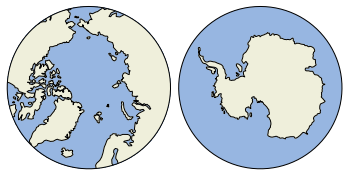

In [89]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(gs[0,0], projection=ccrs.NorthPolarStereo())
ax1.set_extent((-180,180,60,90), crs=ccrs.PlateCarree())

ax2 = plt.subplot(gs[0,1], projection=ccrs.SouthPolarStereo())
ax2.set_extent((-180,180,-90,-60), crs=ccrs.PlateCarree())

layout_ax(ax1)
set_circular_boundary(ax1)
layout_ax(ax2)
set_circular_boundary(ax2)

fig.subplots_adjust(wspace=0.05)

# Example 4: custom coastlines

Sometimes you want to single out a single continent or country. Custom coastlines will help you do that. 

In [90]:
import cartopy.io.shapereader as shpreader


def get_shape_country(country_name='Greenland'):
    """
    function based on a StackExchange post by Antonio Falciano
    https://gis.stackexchange.com/questions/88209/python-mapping-in-matplotlib-cartopy-color-one-country
    """
    shpfilename = shpreader.natural_earth(resolution='50m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['NAME_LONG'] == country_name:
            my_shape = country.geometry
            return my_shape
        
    raise LookupError("Country not found in database: "+country_name)

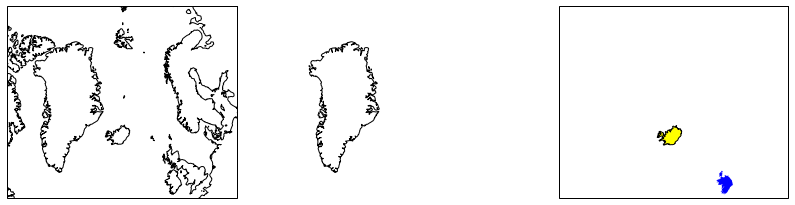

In [153]:
fig = plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(1, 3)

myproj = ccrs.Stereographic(central_longitude=-40, central_latitude=72)
extent = [-60,20,55, 90]

ax1 = plt.subplot(gs[0,0], projection=myproj)
ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')

ax2 = plt.subplot(gs[0,1], projection=myproj)
ax2.set_extent(extent, crs=ccrs.PlateCarree())
ax2.add_geometries(get_shape_country('Greenland'), ccrs.PlateCarree(),
          edgecolor='black', facecolor='white', zorder=0)
ax2.outline_patch.set_visible(False) # disable Axes frame

ax3 = plt.subplot(gs[0,2], projection=myproj)
ax3.set_extent(extent, crs=ccrs.PlateCarree())
ax3.add_geometries(get_shape_country('Iceland'), ccrs.PlateCarree(),
          edgecolor='black', facecolor='yellow', zorder=0)
ax3.add_geometries(get_shape_country('Ireland'), ccrs.PlateCarree(),
          edgecolor=None, facecolor='blue', zorder=0)

# Example 5: project NetCDF data onto a map

Contouring gridded data onto a map is a typical use case for Cartopy.

In [128]:
import xarray as xr
ds = xr.open_dataset("zonal_wind.nc")

U500 = ds.U500.squeeze() # Squeeze() removes any superfluous length-1 dimensions
print(U500.dims, U500.shape)

('lat', 'lon') (192, 288)


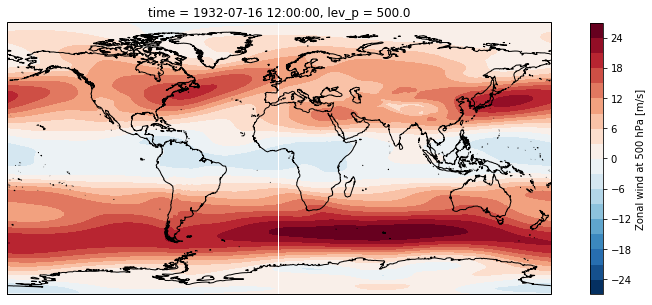

In [121]:
fig = plt.figure(figsize=(14,5))
ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')

U500.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=21)

Some datasets do not display right when you contour them this way, e.g. when the grid is irregular. In that case it may be necessary to use the 2-dimensional coordinate arrays (`lon2d`, `lat2d`) as below. 

In [124]:
# Define 2-dimensional coordinate arrays lat2d and lon2d, as they are not present in our regular dataset
# This step can be skipped when the dataset is irregular, and these coordinate arrays are
# already known.

lon = ds.lon
lat = ds.lat
lon2d, lat2d = np.meshgrid(lon,lat)

U500.coords['lon2d'] = xr.DataArray(lon2d, dims=('lat', 'lon'))
U500.coords['lat2d'] = xr.DataArray(lat2d, dims=('lat', 'lon'))  

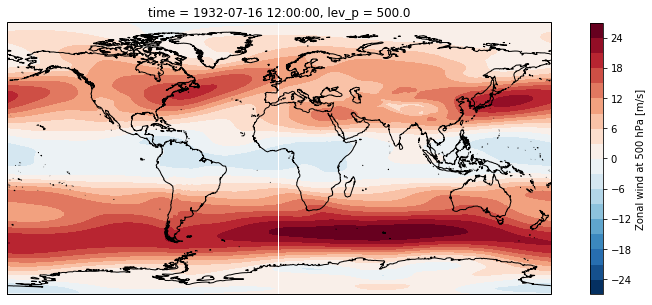

In [125]:
fig = plt.figure(figsize=(14,5))
ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')

U500.plot.contourf('lon2d', 'lat2d', ax=ax1, transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=21)

# Example 6: shared labelbar

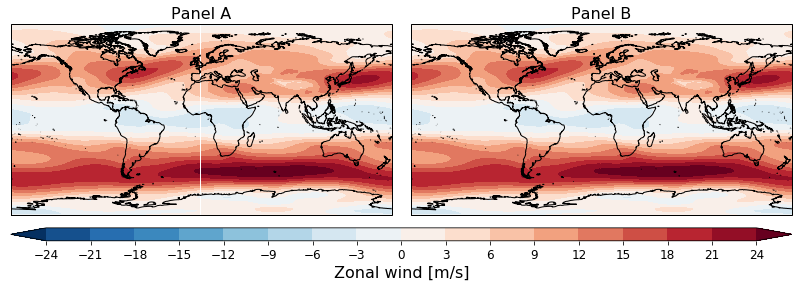

In [150]:
fig = plt.figure(figsize=(14,6))
ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax2 = plt.subplot(122, projection=ccrs.PlateCarree())

levels = np.linspace(-24, 24, 48//3+1)

cn = U500.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), cmap='RdBu_r', 
                   levels=levels, extend='both', add_colorbar=False)
cn = U500.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(), cmap='RdBu_r', 
                   levels=levels, extend='both', add_colorbar=False)

for title, ax in zip(['Panel A', 'Panel B'], [ax1, ax2]):
    ax.coastlines(resolution='50m')
    ax.set_title(title, fontsize=16)
    
fig.subplots_adjust(wspace=0.05)

pos1 = ax1.get_position() 
pos2 = ax2.get_position() 

######################
## Labelbar
######################
cbar_ax = fig.add_axes([pos1.x0 , pos1.y0-0.06, pos2.x1-pos1.x0, 0.03]) # xpos, ypos, w, h
cb = fig.colorbar(cn, cax=cbar_ax, orientation='horizontal')
cb.set_label("Zonal wind [m/s]", fontsize=16)
cb.set_ticks(levels) # tick at every level
cb.ax.tick_params(labelsize=12) # tick font size

# Example 7: putting everything together

Here's a figure I made recently using techniques presented in this notebook. 

![](Example_cartopy_shapes.png)